In [15]:
from classes import *
import matplotlib.pyplot as plt
import time
import numpy as np

In [141]:
settings = []
# V1 base settings - max output at 10 with 4 offices, 2 warehouse, 4 emps in each department, all outputs fully used
# 3% of random combinations give positive results
settings.append(GameSettings(base_emp_value = 1, 
                             base_emp_cost = 1,
                             base_bud_value = 4,
                             base_bud_cost = 1,
                             engineering_to_unit_cost = {0:5,1:4,2:3,3:2,4:1},
                             marketing_to_brand = {0:2,1:3,2:4,3:5,4:6},
                             finance_to_max_gross = {0:4,1:8,2:16,3:24,4:32},
                             operations_to_max_buildings = {0:2,1:3,2:4,3:5,4:6},
                             price_to_demand = {1:6,2:5,3:4,4:3,5:2} 
                            ))
# V2 - same settings as the base, but each employee only costs 0.5
# 10% of random combinations give positive results
settings.append(GameSettings(base_emp_value = 1,
                             base_emp_cost = 0.5,
                             base_bud_value = 4,
                             base_bud_cost = 1,
                             engineering_to_unit_cost = {0:5,1:4,2:3,3:2,4:1},
                             marketing_to_brand = {0:2,1:3,2:4,3:5,4:6},
                             finance_to_max_gross = {0:4,1:8,2:16,3:24,4:32},
                             operations_to_max_buildings = {0:2,1:3,2:4,3:5,4:6},
                             price_to_demand = {1:6,2:5,3:4,4:3,5:2} 
                            ))

In [142]:
res_dfs, count = [], 0
for setting in settings:
    start_time = time.time()
    game = Game(setting, no_players = 1)
    res = game.players[0].generate_game_states(setting, game.companies[0], iterations = 10000, debug = 0)
    net_list = res['net'].tolist()
    pos_rat = len([x for x in net_list if x > 0])/len(net_list)
    print('---- finished simulation for setting: ' + str(count) + ' time: ' + str((time.time() - start_time)) + ' seconds ----')
    print('mean: ' + str(np.mean(net_list)) + ', std: ' + str(np.std(net_list)) + ', pos ratio: ' + str(pos_rat))
    print(res[0:10][['key','net']])
    res_dfs.append(res)
    count += 1

---- finished simulation for setting: 0 time: 0.4117419719696045 seconds ----
mean: -9.812894183601962, std: 4.626448351565148, pos ratio: 0.015416958654519973
                        key  net
4437  (4, 4, 4, 4, 4, 2, 5)   10
4189  (4, 4, 4, 3, 4, 2, 5)    7
913   (3, 3, 4, 2, 3, 2, 5)    7
1725  (1, 2, 4, 0, 2, 1, 5)    6
968   (1, 3, 4, 0, 2, 1, 5)    5
805   (1, 2, 4, 1, 2, 1, 5)    5
1063  (2, 2, 4, 0, 2, 1, 5)    5
4579  (3, 3, 4, 2, 3, 2, 4)    4
2510  (4, 4, 4, 2, 4, 2, 5)    4
1322  (3, 3, 3, 3, 3, 2, 5)    4
---- finished simulation for setting: 1 time: 0.4299197196960449 seconds ----
mean: -5.297906035544607, std: 4.119490227304395, pos ratio: 0.09677986978708429
                        key   net
4753  (4, 4, 4, 4, 4, 2, 5)  18.0
3298  (4, 4, 4, 3, 4, 2, 5)  14.5
4300  (3, 3, 4, 2, 3, 2, 5)  13.0
4497  (4, 3, 4, 2, 4, 2, 5)  11.5
2717  (4, 4, 4, 2, 4, 2, 5)  11.0
5305  (4, 3, 3, 4, 4, 2, 5)  11.0
697   (4, 3, 4, 4, 4, 2, 5)  10.5
4569  (4, 4, 3, 4, 4, 2, 5)  10.5
5551  (4, 4,

In [140]:
special_keys = [
    (4, 4, 4, 4, 4, 2, 5), # max employees + 4 offices and 2 warehouses
]
for i in range(len(settings)):
    print('--- special keys for setting: ' + str(0))
    setting = settings[i]
    game = Game(setting, no_players = 1)
    for key in special_keys:
        print('key: ' + str(key))
        game.companies[0].analyse_game_state(key, debug=1)
        print()

for i in range(len(settings)):
    print('--- top 3 results from setting: ' + str(0))
    setting = settings[i]
    game = Game(setting, no_players = 1)
    for key in res_dfs[i][:3]['key']:
        print('key: ' + str(key))
        game.companies[0].analyse_game_state(key, debug=1)
        print()

--- special keys for setting: 0
key: (4, 4, 4, 4, 4, 2, 5)
A, employees: 16/16, operations: 4, engineering: 4, finance: 4, marketing: 4
B, buildings: 6/6, production: 8, desks: 16
C, price: 5, price demand: 2, brand demand: 6, demand strength: 8, actual demand: 8
D, unit cost: 1, unit profit: 4, units sold: 8
E, gross income: 32/32, actual gross: 32, total cost: 22, net: 10

--- special keys for setting: 0
key: (4, 4, 4, 4, 4, 2, 5)
A, employees: 16/16, operations: 4, engineering: 4, finance: 4, marketing: 4
B, buildings: 6/6, production: 8, desks: 16
C, price: 5, price demand: 2, brand demand: 6, demand strength: 8, actual demand: 8
D, unit cost: 1, unit profit: 4, units sold: 8
E, gross income: 32/32, actual gross: 32, total cost: 14.0, net: 18.0

--- top 3 results from setting: 0
key: (4, 4, 4, 4, 4, 2, 5)
A, employees: 16/16, operations: 4, engineering: 4, finance: 4, marketing: 4
B, buildings: 6/6, production: 8, desks: 16
C, price: 5, price demand: 2, brand demand: 6, demand stre

(array([0.00683783, 0.0271859 , 0.05801129, 0.07168696, 0.07703591,
        0.05200062, 0.01494397, 0.00386007, 0.00077201, 0.00016543]),
 array([-22. , -18.8, -15.6, -12.4,  -9.2,  -6. ,  -2.8,   0.4,   3.6,
          6.8,  10. ]),
 <BarContainer object of 10 artists>)

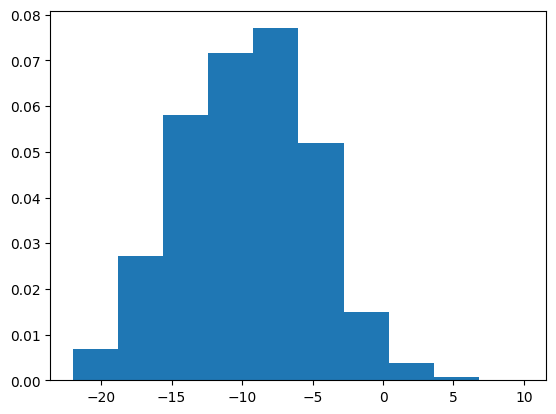

In [130]:
res_arr = res_dfs[1]['net'].to_numpy()
plt.hist(res_arr, density=True)